# Hierarchical Attention Network for Document Classification


# Import libraries


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#import pip
#import theano
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.utils import plot_model, register_keras_serializable
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import SGD



[nltk_data] Downloading package punkt to /Users/lanado/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lanado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lanado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Set the logging level to ERROR to suppress warnings
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Additionally, suppress other warnings if needed
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Functions

In [3]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list


def split_df(dataframe, column_name, training_split=0.8, validation_split=0.2):
    if training_split + validation_split != 1.0:
        raise ValueError('Split parameter sum should be 1.0')

    # Shuffle and split the data
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
        .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    validation = dataframe.drop(train.index).sample(frac=1)

    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))

    return train, validation


def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data


def to_categorical(series, n_classes=5):
    # Initialize an array of zeros with the shape (number of samples, number of classes)
    y_cat = np.zeros((len(series), n_classes))
    
    # Set the appropriate element to 1
    y_cat[np.arange(len(series)), series] = 1
    
    return y_cat


# Attention layer

In [5]:
from tensorflow.keras.models import load_model
model = load_model('Model_10epoch_glove_yelp.keras')

In [7]:
df_train = pd.read_csv('trees/sst_train.txt', sep='\t', header=None, names=['label', 'text'])
df_dev = pd.read_csv('trees/sst_dev.txt', sep='\t', header=None, names=['label', 'text'])
df_test = pd.read_csv('trees/sst_test.txt', sep='\t', header=None, names=['label', 'text'])

In [9]:
df_train = pd.concat([df_train,df_dev], axis = 0)

In [10]:
df_train

,label,text
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .
...,...,...
1096,1,it seems to me the film is about the art of ri...
1097,1,It 's just disappointingly superficial -- a mo...
1098,1,The title not only describes its main characte...
1099,2,Sometimes it feels as if it might have been ma...


In [19]:
# Convert all values in the 'text' column to strings
df_train['text'] = df_train['text'].astype(str)


# Parameters

In [22]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 200      # vector size of word embedding

# Data Preprocessing

In [23]:

def clean_articles(dataframe):
    articles = []
    n = dataframe.shape[0]
    col_number = dataframe.columns.get_loc('text')
    stopWords = set(stopwords.words('english'))
    data_cleaned = dataframe.copy()

    for i in range(n):
        temp_string, idx_string = cleanString(dataframe.iloc[i, col_number], stopWords)
        articles.append(temp_string)
        print(str(i+1) + ' of ' + str(n) + " articles cleaned.", end='\r')

    data_cleaned.loc[:, 'text'] = pd.Series(articles, index=dataframe.index)
    return data_cleaned



In [24]:
data_cleaned = clean_articles(df_train)

In [25]:
data_cleaned_test = clean_articles(df_test)

In [26]:
data_cleaned.head()

,label,text
0,3,rock destined 21st century new conan going mak...
1,4,gorgeously elaborate continuation lord ring tr...
2,3,bryan adam contributes slew song potential hit...
3,2,think america would enough plucky british ecce...
4,3,yet act still charming .


# Tokenization

In [27]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
def tokenization(data):
    texts = []
    n = data['text'].shape[0]
    for i in range(n):
        s = data['text'].iloc[i]
        s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) != ""])
        texts.append(s)
    tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
    tokenizer.fit_on_texts(texts)
    word_index = tokenizer.word_index
    return tokenizer, word_index

tokenizer, word_index = tokenization(data_cleaned)
#val_tokenizer, val_word_index = tokenization(data_cleaned_val)

## GloVe Embedding Matrix

In [28]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
def embedding(tokenizer,word_index):
    embeddings_index = {}
    f = open(os.path.join(os.getcwd(), 'glove.6B.200d.txt'),encoding='UTF-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    # Search words in our word index in the pre-trained dataset
    # Create an embedding matrix for our bbc dataset
    min_wordCount = 2
    absent_words = 0
    small_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    word_counts = tokenizer.word_counts
    for word, i in word_index.items():
        if word_counts[word] > min_wordCount:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
            else:
                absent_words += 1
        else:
            small_words += 1
    print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
        '% of total words')
    print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
        '% of total words')
    return embedding_matrix
    
embedding_matrix = embedding(tokenizer, word_index)
#embedding_matrix_val = embedding(val_tokenizer, val_word_index)

Found 400000 word vectors.
Total absent words are 10 which is 0.07 % of total words
Words with 2 or less mentions 8641 which is 61.24 % of total words


# Splitting Data Set

In [30]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""
#print(categoryToCode)

train, validation= split_df(data_cleaned, 'label',0.8,0.2)
from tensorflow.keras.utils import to_categorical
#Training
paras = []
for i in range(data_cleaned['text'].shape[0]):
    sequence = wordToSeq(df_train['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
num_classes = 5
y_train = to_categorical(data_cleaned['label'],num_classes)

#Validation
paras = []
for i in range(validation['text'].shape[0]):
    sequence = wordToSeq(validation['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['label'],num_classes)



/var/folders/pn/jrl8dp3x15nfyh50_q0l49km0000gn/T/ipykernel_30380/2502587804.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\


Total:  9645
Training:  7716 , Percentage:  0.8
Validation:  1591 , Percentage:  0.16495593571798858


In [31]:
#Test
paras = []
for i in range(data_cleaned_test['text'].shape[0]):
    sequence = wordToSeq(df_test['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
num_classes = 5
y_test = to_categorical(data_cleaned_test['label'],num_classes)

In [32]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [33]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [36]:
from tensorflow.keras.optimizers import Adam

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])


## Train

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 137s 731ms/step - acc: 0.2468 - loss: 1.8076 - val_acc: 0.2646 - val_loss: 1.7812
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 109s 719ms/step - acc: 0.2515 - loss: 1.7850 - val_acc: 0.2615 - val_loss: 1.7699
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 109s 724ms/step - acc: 0.2593 - loss: 1.7789 - val_acc: 0.2627 - val_loss: 1.7590
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 110s 726ms/step - acc: 0.2587 - loss: 1.7472 - val_acc: 0.2652 - val_loss: 1.7490
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 110s 730ms/step - acc: 0.2615 - loss: 1.7441 - val_acc: 0.2678 - val_loss: 1.7393
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 104s 690ms/step - acc: 0.2565 - loss: 1.7464 - val_acc: 0.2703 - val_loss: 1.7301
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 107s 706ms/step - acc: 0.2659 - loss: 1.7322 - val_acc: 0.2684 - val_loss: 1.7213
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 109s 725ms/step - acc: 0.2620 - loss: 1.7187 - val_acc: 0.2671 - val_loss: 1.7132
Epoch 9/10
151/151 ━━━━━

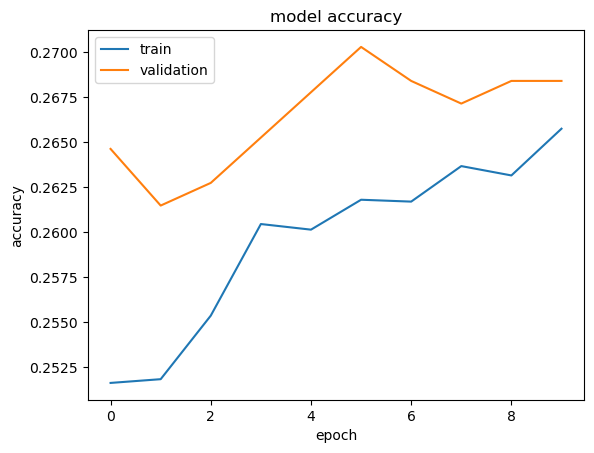

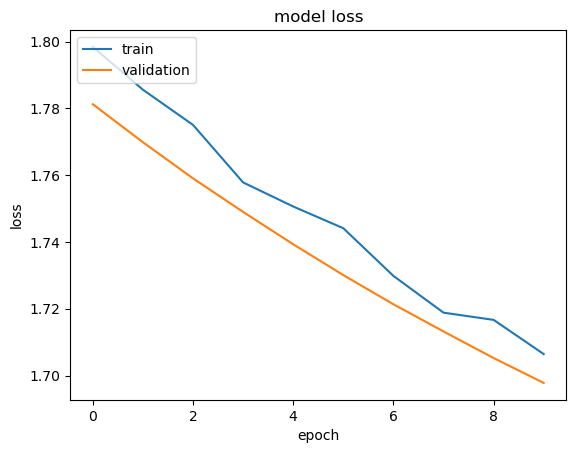

In [37]:
# Fine-tune the model on SST-5 dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [38]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 133s 440ms/step - acc: 0.2671 - loss: 1.7028 - val_acc: 0.2696 - val_loss: 1.6847
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 133s 441ms/step - acc: 0.2681 - loss: 1.6882 - val_acc: 0.2709 - val_loss: 1.6735
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 133s 442ms/step - acc: 0.2696 - loss: 1.6690 - val_acc: 0.2690 - val_loss: 1.6640
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 138s 457ms/step - acc: 0.2633 - loss: 1.6682 - val_acc: 0.2652 - val_loss: 1.6555
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 131s 435ms/step - acc: 0.2666 - loss: 1.6450 - val_acc: 0.2640 - val_loss: 1.6481
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 125s 414ms/step - acc: 0.2640 - loss: 1.6476 - val_acc: 0.2665 - val_loss: 1.6413
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 125s 412ms/step - acc: 0.2688 - loss: 1.6409 - val_acc: 0.2696 - val_loss: 1.6352
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 124s 412ms/step - acc: 0.2684 - loss: 1.6397 - val_acc: 0.2696 - val_loss: 1.6296
Epoch 9/20
302/302 ━━━━━

In [39]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 129s 429ms/step - acc: 0.2683 - loss: 1.5814 - val_acc: 0.2740 - val_loss: 1.5909
Epoch 2/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 132s 436ms/step - acc: 0.2653 - loss: 1.5957 - val_acc: 0.2747 - val_loss: 1.5895
Epoch 3/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 132s 437ms/step - acc: 0.2594 - loss: 1.5857 - val_acc: 0.2728 - val_loss: 1.5880
Epoch 4/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 134s 444ms/step - acc: 0.2695 - loss: 1.5785 - val_acc: 0.2734 - val_loss: 1.5868
Epoch 5/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 132s 436ms/step - acc: 0.2819 - loss: 1.5790 - val_acc: 0.2740 - val_loss: 1.5856
Epoch 6/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 124s 410ms/step - acc: 0.2743 - loss: 1.5836 - val_acc: 0.2690 - val_loss: 1.5845
Epoch 7/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 125s 414ms/step - acc: 0.2759 - loss: 1.5852 - val_acc: 0.2678 - val_loss: 1.5836
Epoch 8/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 125s 414ms/step - acc: 0.2652 - loss: 1.5816 - val_acc: 0.2678 - val_loss: 1.5826
Epoch 9/50
302/302 ━━━━━

## Test

In [40]:
model.evaluate(x=x_test, y=y_test, batch_size=None,verbose=1,sample_weight=None)

70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - acc: 0.2822 - loss: 1.5732


[1.5795944929122925, 0.2678733170032501]